In [140]:
import pathlib, re, pickle, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from elyawy.constants import SUMSTATS_LIST, SUMSTATS_DEFINITION
from elyawy.io import load_sims_df
from scipy import stats as st
from sklearn import decomposition, exceptions
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, PoissonRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin# define the transformer
warnings.simplefilter("ignore", category=exceptions.ConvergenceWarning)

class StandardMemoryScaler(BaseEstimator, TransformerMixin):

    def __init__(self, epsilon=1e-4):
        self._epsilon = epsilon
        
    def fit(self, X, y = None):
        self._mean = X.mean()
        self._std = X.std()

        return self

    def transform(self, X):
        X = (X-self._mean)/(self._std+self._epsilon)
       
        return X

    def inverse_transform(self, X_scaled):
        X = X_scaled*(self._std+self._epsilon) + self._mean
        return X


In [105]:
MAIN_PATH = '''/home/elyawy/Data'''

MAIN_PATH = pathlib.Path(re.sub(r"\n\s*","", MAIN_PATH))

In [141]:
true_stats_with_params = pd.DataFrame()
realinged_stats = pd.DataFrame()
for data in ["test"]:
    temp_true_df = pd.read_parquet(MAIN_PATH / data / "true_stats.parquet.gzip")
    temp_realigned_df = pd.read_parquet(MAIN_PATH / data / "realigned_stats.parquet.gzip")
    true_stats_with_params = pd.concat([true_stats_with_params,temp_true_df])
    realinged_stats = pd.concat([realinged_stats,temp_realigned_df])
true_stats_with_params = true_stats_with_params.reset_index(drop=True)
realinged_stats = realinged_stats.reset_index(drop=True)



In [142]:
shuffle_index = list(range(len(true_stats_with_params)))
np.random.seed(420)
np.random.shuffle(shuffle_index)
X = true_stats_with_params.loc[shuffle_index,:].reset_index(drop=True)
Y = realinged_stats.loc[shuffle_index,:].reset_index(drop=True)

In [146]:
def make_regressor(X,Y, examined_stat=None, sample_size=100, clf=None, param_grid={}):
    X,Y = X[0:sample_size], Y[0:sample_size]
    X_train, X_test, y_train, y_test = train_test_split(X, Y[examined_stat],
                                                        train_size=0.8, random_state=420)
    scaler = StandardMemoryScaler()
    scaler.fit(X_train, y_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    clf_cv = GridSearchCV(clf, param_grid, cv=5, scoring="neg_mean_squared_error")

    clf_cv.fit(X=X_train, y=y_train)

    best_clf = clf_cv.best_estimator_

    correlation_train = st.pearsonr(best_clf.predict(X_train), y_train)[0]
    correlation_test = st.pearsonr(best_clf.predict(X_test), y_test)[0]

    rmse_train = np.sqrt(-clf_cv.best_score_)
    rmse_test = np.sqrt(mean_squared_error(y_test, best_clf.predict(X_test)))

    return (rmse_test, correlation_test, rmse_train, correlation_train)

In [153]:
def asses_regressor(X,Y, examined_stat=None, sample_size=100, clf=None):
    X,Y = X[0:sample_size], Y[0:sample_size]
    X_train, X_test, y_train, y_test = train_test_split(X, Y[examined_stat],
                                                        train_size=0.8, random_state=420)
    scaler = StandardMemoryScaler()
    scaler.fit(X_train, y_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    clf.fit(X=X_train, y=y_train)

    correlation_train = st.pearsonr(clf.predict(X_train), y_train)[0]
    print(correlation_train)
    correlation_test = st.pearsonr(clf.predict(X_test), y_test)[0]

    rmse_train = np.sqrt(-clf.best_score_)
    rmse_test = np.sqrt(mean_squared_error(y_test, clf.predict(X_test)))

    return (rmse_test, correlation_test, rmse_train, correlation_train)

In [154]:
results_metrics = {}
clf_ = Lasso()
param_grid_ = {
              'alpha': np.logspace(-7,4,20)
             }
for i in tqdm(map(round, np.linspace(100, 2000, 20))):
    results_metrics[i] = make_regressor(X,Y, examined_stat="19", sample_size=i,
                                        clf=clf_, param_grid=param_grid_)

20it [00:39,  1.97s/it]


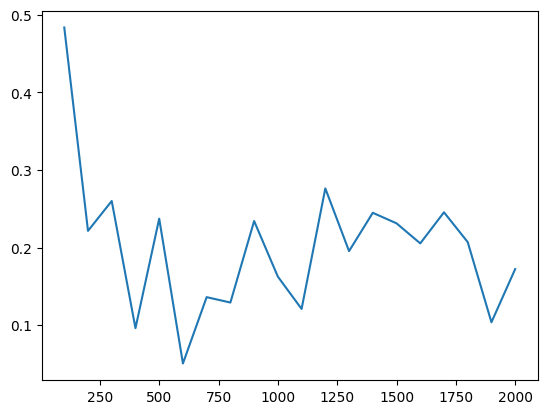

In [157]:
metrics_list = [(key, val[1]) for key,val in results_metrics.items()]
sample_sizes_, metrics_ = zip(*metrics_list)
plt.plot(sample_sizes_, metrics_)

In [158]:
metrics_

(0.4838156976928834,
 0.22156117993825208,
 0.26007626451328647,
 0.0960914420174767,
 0.23734696563963137,
 0.05059032586505876,
 0.13612688821765367,
 0.12915905668864322,
 0.2342758816909084,
 0.1625703982894778,
 0.12093702197030673,
 0.2763263241777967,
 0.19546250621399072,
 0.2448738431581924,
 0.23130359724196853,
 0.20543608644055672,
 0.24551669879044108,
 0.20710570109803284,
 0.10372858412526555,
 0.17229458377237983)

In [121]:
examined_stat = "19"
X_train, X_test, y_train, y_test = train_test_split(X, Y[examined_stat],
                                                    train_size=0.8, random_state=420)

In [122]:
scaler = StandardMemoryScaler()
scaler.fit(X_train, y_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [124]:
clf = RandomForestRegressor()

# Criterion
criterion = ['squared_error', 'absolute_error','poisson']
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Maximum number of levels in tree
max_depth = [3,5,7,9]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
param_grid = {
              'criterion': criterion,
              'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap
             }
clf_forestcv = RandomizedSearchCV(clf, param_grid, cv=5, scoring="neg_mean_squared_error")

clf_forestcv.fit(X=X_train, y=y_train)

# true_stats = true_stats_with_params[map(str, range(5,len(true_stats_with_params.columns)))]
# true_stats.columns = map(str, range(0,27))
print(np.sqrt(-clf_forestcv.best_score_))
print(st.pearsonr(clf_forestcv.predict(X_train), y_train)[0]**2)

0.26731193200260556
0.18420354939993203


In [159]:
for i in tqdm(map(round, np.linspace(100, 2000, 20))):
    results_metrics[i] = make_regressor(X,Y, examined_stat="19", sample_size=i,
                                        clf=clf_forestcv.best_estimator_)

20it [04:38, 13.92s/it]


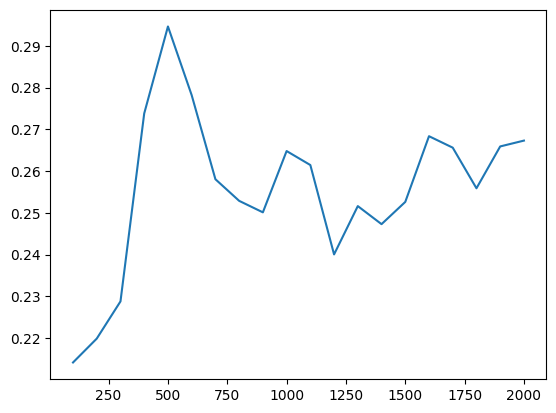

In [137]:
metrics_list = [(key, val[2]) for key,val in results_metrics.items()]
sample_sizes_, metrics_ = zip(*metrics_list)
plt.plot(sample_sizes_, metrics_)

In [125]:
print(np.sqrt(-clf_forestcv.best_score_))
print(st.pearsonr(clf_forestcv.predict(X_train), y_train)[0]**2)

0.26731193200260556
0.18420354939993203


In [52]:
with open("models_cv.pickle", 'wb') as f:
    pickle.dump(clf_forestcv,f,protocol=pickle.HIGHEST_PROTOCOL)


In [36]:
with open("models_cv.pickle", 'rb') as f:
    clf_forestcv = pickle.load(f)


In [38]:
best_clf = clf_forestcv.best_estimator_

In [39]:
best_clf

RandomForestRegressor(criterion='poisson', max_depth=5, min_samples_split=5,
                      n_estimators=1550)

In [66]:
print(np.sqrt(mean_squared_error(y_test, best_clf.predict(X_test))))
print(st.pearsonr(best_clf.predict(X_test), y_test)[0]**2)

0.13859910026490732
0.4707283501221001


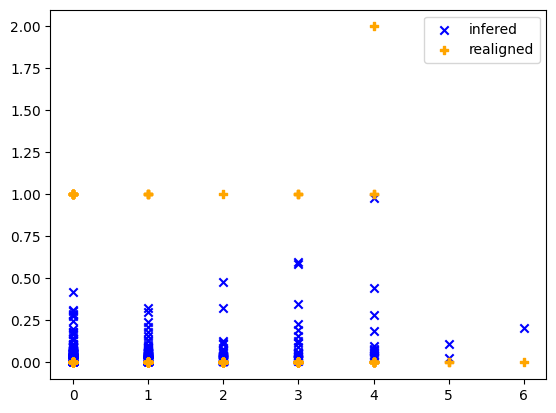

In [67]:
# x_true = X_test[str(int(examined_stat)+5)]
# x_true = X_train[str(int(examined_stat)+5)]
x_true = scaler.inverse_transform(X_train)[str(int(examined_stat)+5)]

plt.scatter(x_true, best_clf.predict(X_train),
            marker='x', label="infered", c="blue")
plt.scatter(x_true, y_train,
            marker="P", label="realigned", c="orange")
            
plt.legend()
# plt.scatter(true_stats[selected_feature], infered_stat,
#             marker="P", label="infered")
# plt.scatter(true_stats[selected_feature], realinged_stats[selected_feature],
#             marker='x', label="realigned")
